In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

In [3]:
diccionario_tipos = {
    "tipodepropiedad":"category",
    "provincia":"category",
    "provincia":"category",
    #"habitaciones":"int",
    #"garages":"int",
    #"banos":"int",
    #'metroscubiertos':, 'metrostotales', 'idzona', 'lat', 'lng',
    'gimnasio':"bool",
    'usosmultiples':"bool",
    'piscina':"bool",
    'escuelascercanas':"bool",
    'centroscomercialescercanos':"bool"
}
df = pd.read_csv("data/train.csv", dtype = diccionario_tipos)

FileNotFoundError: [Errno 2] File b'data/train.csv' does not exist: b'data/train.csv'

In [4]:
df[["metrostotales", "metroscubiertos"]].isna().sum()

metrostotales      51467
metroscubiertos    17400
dtype: int64

In [5]:
 porcentaje_metros_nulos = df[["metrostotales", "metroscubiertos"]].isna().sum() / df.shape[0]
porcentaje_metros_nulos

metrostotales      0.214446
metroscubiertos    0.072500
dtype: float64

Text(0, 0.5, '')

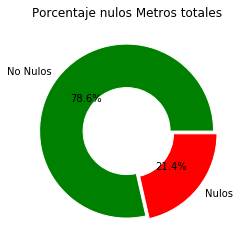

In [6]:
metros = df[["metrostotales", "metroscubiertos"]].copy()
metros["es_nulo_totales"] = metros["metrostotales"].isna().astype(int)
metros["es_nulo_cubiertos"] = metros["metroscubiertos"].isna().astype(int)

g = (metros["es_nulo_totales"].value_counts()/len(metros)).plot("pie", title = "Porcentaje nulos Metros totales",\
    labels=["No Nulos", "Nulos"], wedgeprops={"width":0.5, "edgecolor":'w'}, explode = [0,0.05], autopct='%1.1f%%',\
            colors = ["green", "red"])

g.set_ylabel("")


0    0.9275
1    0.0725
Name: es_nulo_cubiertos, dtype: float64

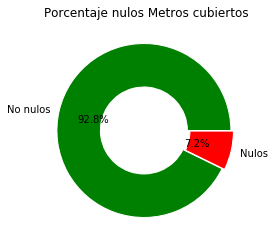

In [7]:
porcentaje_metros_cub_nulos = metros["es_nulo_cubiertos"].value_counts(ascending=False)/len(metros)

g = porcentaje_metros_cub_nulos.plot("pie", title = "Porcentaje nulos Metros cubiertos",\
    labels=["No nulos", "Nulos"], wedgeprops={"width":0.5, "edgecolor":'w'}, explode = [0.03,0], autopct='%1.1f%%',
                                    colors = ["green", "red"])
g.set_ylabel("")
porcentaje_metros_cub_nulos

Podemos ver como las columnas "Metros totales" y "Metros cubiertos" tienen una gran cantidad de nulos, principalmente "Metros totales" que tiene un 21% de nulos.

In [8]:
df.loc[(df["metrostotales"] == 0) | (df["metroscubiertos"] == 0)].shape

(0, 23)

In [9]:
df.loc[(df["metrostotales"].isna()) & (df["metroscubiertos"].isna())].shape

(0, 23)

Por otro lado, estas columnas tienen dos particularidades:
 - No hay **ninguna** entrada que tenga los **dos** campos como nulos al mismo tiempo.
 - En ningún caso tienen como valor **0**.
 
Es decir, no hay ninguna propiedad que tenga las dos caracterísitcas incompletas sin embargo hay gran cantidad de nulos en ambas categorías por separado.

Veamos cual es la relacion entre que datos tiene cada propiedad

In [10]:
df["tiene_los_dos"] = df["metrostotales"].notnull() & df["metroscubiertos"].notnull()
df["tiene_los_dos"].value_counts()

True     171133
False     68867
Name: tiene_los_dos, dtype: int64

In [11]:
propiedades_con_metros= df.loc[df["tiene_los_dos"] == True].copy()
propiedades_con_metros["metros_descubiertos"] = propiedades_con_metros["metrostotales"] - propiedades_con_metros["metroscubiertos"]
propiedades_con_metros["metros_descubiertos"].value_counts().head()

 0.0     37884
 20.0     2583
 10.0     2482
-20.0     2333
-30.0     2098
Name: metros_descubiertos, dtype: int64

Text(0, 0.5, 'Cantidad de propiedades')

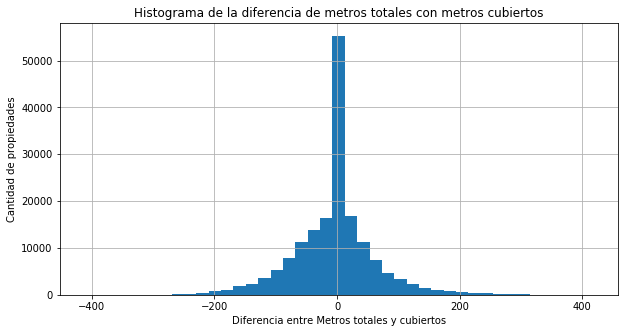

In [12]:
fig = plt.figure(figsize = (10,5))
g = propiedades_con_metros["metros_descubiertos"].hist(bins=41)
plt.title("Histograma de la diferencia de metros totales con metros cubiertos")
g.set_xlabel("Diferencia entre Metros totales y cubiertos")
g.set_ylabel("Cantidad de propiedades")

Proporción de propiedades con MAS metros cubiertos que totales:  0.29289583333333336


Text(0, 0.5, '')

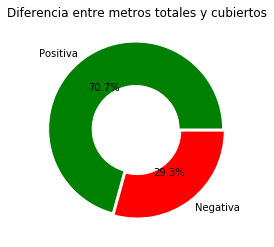

In [13]:
metros["diferencia_negativa"] = (metros["metrostotales"] < metros["metroscubiertos"]).astype(int)
print("Proporción de propiedades con MAS metros cubiertos que totales: ", \
      metros.loc[metros["diferencia_negativa"], "diferencia_negativa"].sum() / df.shape[0])
g = metros["diferencia_negativa"].value_counts().plot("pie", title = "Diferencia entre metros totales y cubiertos",\
    labels=["Positiva", "Negativa"], wedgeprops={"width":0.5, "edgecolor":'w'}, explode = [0.03,0], autopct='%1.1f%%',
                                    colors = ["green", "red"])
g.set_ylabel("")

Descubrimos que a un 29% de las propiedades tienen una cantidad de metros cubiertos mayor a la de metros totales. Pero haciendo un histograma de la diferencia entre estos dos valores podemos ver que es muy simétrico. 
Dado que sabemos que para ninguno de estos casos los valores son nulos. Deducimos que es muy probable que haya datos ingresados al revez. Es decir, que se ingresó en metros cubiertos el valor que debería estar en metros totales y viceversa.

Text(0, 0.5, 'Proporcion')

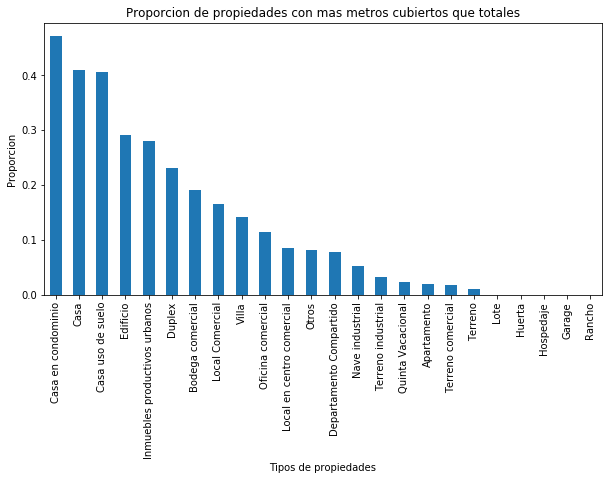

In [14]:
fig = plt.figure(figsize = (10,5))
cantidad_de_tipos_propiedades = df["tipodepropiedad"].value_counts()
cantidad_de_tipos_propiedades_negativos = df.loc[df["metrostotales"] < df["metroscubiertos"], "tipodepropiedad"].copy().value_counts()
proporcion = cantidad_de_tipos_propiedades_negativos / cantidad_de_tipos_propiedades
g = proporcion.sort_values(ascending=False).plot(kind="bar")
plt.title("Proporcion de propiedades con mas metros cubiertos que totales")
g.set_xlabel("Tipos de propiedades")
g.set_ylabel("Proporcion")

Podemos ver como este fenomeno se produce mas en propiedades que es mas común que tengan un poco de terreno descubierto (casas por ejemplo), en propiedades que pueden llegar a tener metros compartidos (edificios con patio común) o propiedades que puedan tener mas de una planta (duplex). Todos estas características suman a la posibilidad de que los datos estén cargados de forma errónea.

#### Vamos a intercambiar los valores de metros totales y cubieros para aquellas propiedades que tienen mas metrs cubiertos que totales

In [15]:
df["swapear"] = df["metrostotales"] < df["metroscubiertos"]
df_metros_arreglados = df.copy()
aux = df_metros_arreglados.loc[df_metros_arreglados["swapear"], "metrostotales"]
if (not aux.empty):
    df_metros_arreglados.loc[df_metros_arreglados["swapear"],"metrostotales"] = \
    df_metros_arreglados.loc[df_metros_arreglados["swapear"], "metroscubiertos"]
    df_metros_arreglados.loc[df_metros_arreglados["swapear"], "metroscubiertos"] = aux
df_metros_arreglados.drop(columns="swapear", inplace=True)
(df_metros_arreglados["metrostotales"] < df_metros_arreglados["metroscubiertos"]).value_counts()


False    240000
dtype: int64

In [16]:
df_metros_arreglados.loc[df_metros_arreglados["metroscubiertos"].isnull() & \
                        df_metros_arreglados["metrostotales"].isnull()].shape

(0, 24)

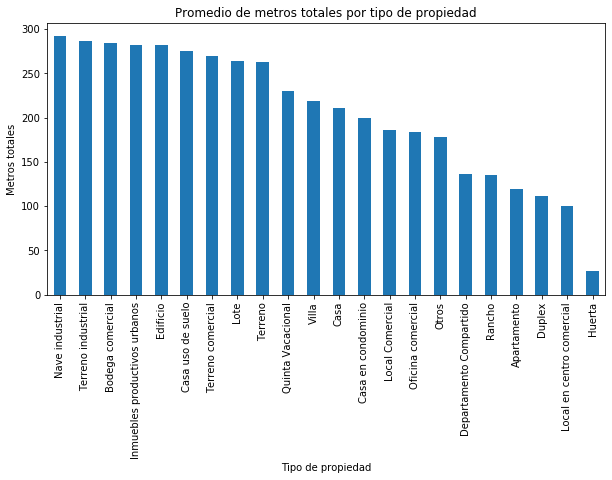

In [17]:

g = df_metros_arreglados.groupby("tipodepropiedad").agg({"metrostotales":"mean"})\
    .sort_values(by="metrostotales", ascending = False)[:-2].plot(kind = "bar", figsize=(10,5))
plt.title("Promedio de metros totales por tipo de propiedad")
g.set_xlabel("Tipo de propiedad")
g.set_ylabel("Metros totales")
g.legend_.remove()

In [18]:
df_metros_arreglados.loc[df_metros_arreglados["tipodepropiedad"].isin(["Hospedaje", "Garage"]), "metrostotales"]

57029    NaN
185590   NaN
Name: metrostotales, dtype: float64

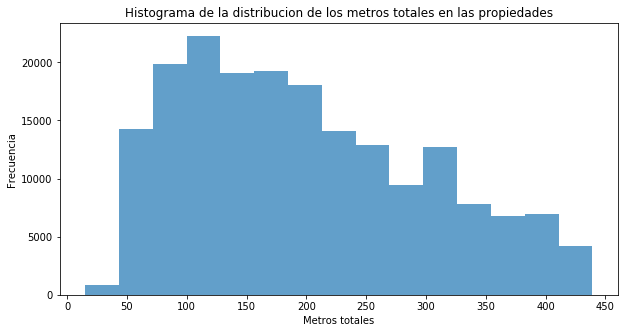

In [19]:
plt.figure(figsize=(10,5))
ax = plt.axes()
g = df_metros_arreglados["metrostotales"].plot.hist(bins=15, alpha = 0.7)
g.set_xlabel("Metros totales")
g.set_ylabel("Frecuencia")
plt.title("Histograma de la distribucion de los metros totales en las propiedades")
ax.xaxis.set_major_locator(ticker.MultipleLocator(50)) 

Text(0, 0.5, 'Frecuencia')

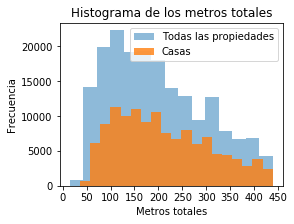

In [20]:
plt.figure(figsize=(4,3))
ax = plt.axes()
casas = df_metros_arreglados.loc[df_metros_arreglados["tipodepropiedad"] == "Casa"].copy()

df_metros_arreglados["metrostotales"].plot.hist(bins=15, alpha = 0.5)
g = casas["metrostotales"].plot.hist(bins=20, alpha = 0.8)
plt.title("Histograma de los metros totales")
ax.xaxis.set_major_locator(ticker.MultipleLocator(50)) 
plt.legend(labels=("Todas las propiedades", "Casas"))
g.set_xlabel("Metros totales")
g.set_ylabel("Frecuencia")

Text(0, 0.5, 'Frecuencia')

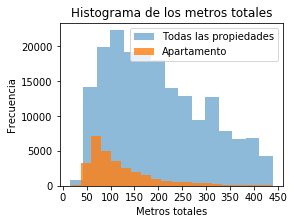

In [21]:
plt.figure(figsize=(4,3))
ax2 = plt.axes()
apartamentos = df_metros_arreglados.loc[df_metros_arreglados["tipodepropiedad"] == "Apartamento"].copy()
df_metros_arreglados["metrostotales"].plot.hist(bins=15, alpha = 0.5)
h = apartamentos["metrostotales"].plot.hist(bins=20, alpha = 0.8)

plt.title("Histograma de los metros totales")
ax2.xaxis.set_major_locator(ticker.MultipleLocator(50)) 
plt.legend(labels=("Todas las propiedades", "Apartamento"))
h.set_xlabel("Metros totales")
h.set_ylabel("Frecuencia")

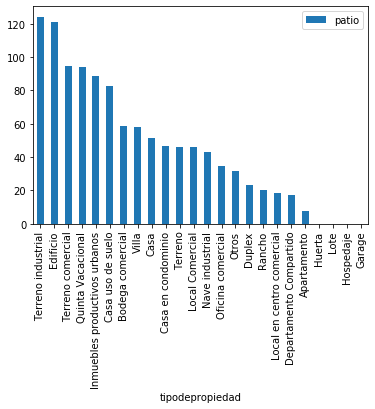

In [22]:
df_metros_arreglados["patio"] = df_metros_arreglados["metrostotales"] - df_metros_arreglados["metroscubiertos"]
df_metros_arreglados.groupby("tipodepropiedad").agg({"patio":"mean"}).sort_values(by="patio", ascending = False).plot(kind = "bar")

#### Alanizamos como afectan los metros al precio

In [23]:
def clasificar_por_tamanio(fila):
    if fila["metrostotales"] in range(0, 70): return "Chico"
    if fila["metrostotales"] in range(70, 150): return "Mediano"
    if fila["metrostotales"] in range(150, 250): return "Grande"
    if fila["metrostotales"] in range(250, 500): return "Muy grande"
df_metros_arreglados["clasif_tamanio"] = df_metros_arreglados.apply(clasificar_por_tamanio, axis=1)


Veremos a continuación cuales son los tipos de propiedad que predominan en cada Tamaño de la clasificación.

Text(0, 0.5, 'Cantidad de publicaciones')

<Figure size 144x144 with 0 Axes>

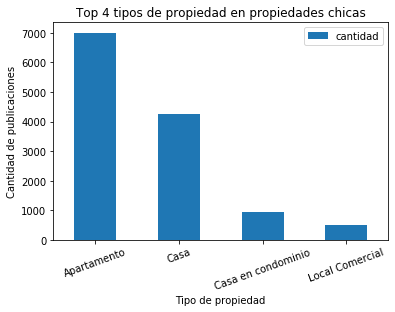

In [24]:
plt.figure(figsize=((2,2)))
df_metros_arreglados["cantidad"] = 1
por_tamanio_y_tipo = df_metros_arreglados.groupby(["clasif_tamanio", "tipodepropiedad"]).agg({"cantidad":np.sum}).reset_index().set_index("tipodepropiedad")
g = por_tamanio_y_tipo.loc[por_tamanio_y_tipo["clasif_tamanio"] == "Chico"].nlargest(4,columns="cantidad").plot(kind = "bar", rot=20)
plt.title("Top 4 tipos de propiedad en propiedades chicas")
g.set_xlabel("Tipo de propiedad")
g.set_ylabel("Cantidad de publicaciones")

Text(0, 0.5, 'Cantidad de publicaciones')

<Figure size 144x144 with 0 Axes>

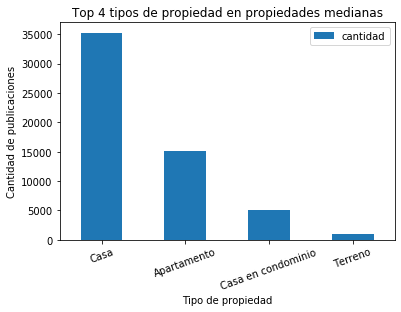

In [25]:
plt.figure(figsize=((2,2)))
df_metros_arreglados["cantidad"] = 1
por_tamanio_y_tipo = df_metros_arreglados.groupby(["clasif_tamanio", "tipodepropiedad"]).agg({"cantidad":np.sum}).reset_index().set_index("tipodepropiedad")
g = por_tamanio_y_tipo.loc[por_tamanio_y_tipo["clasif_tamanio"] == "Mediano"].nlargest(4,columns="cantidad").plot(kind = "bar", rot=20)
plt.title("Top 4 tipos de propiedad en propiedades medianas")
g.set_xlabel("Tipo de propiedad")
g.set_ylabel("Cantidad de publicaciones")

Text(0, 0.5, 'Cantidad de publicaciones')

<Figure size 216x144 with 0 Axes>

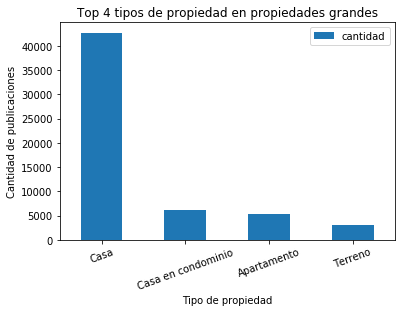

In [26]:
plt.figure(figsize=((3,2)))
df_metros_arreglados["cantidad"] = 1
por_tamanio_y_tipo = df_metros_arreglados.groupby(["clasif_tamanio", "tipodepropiedad"]).agg({"cantidad":np.sum}).reset_index().set_index("tipodepropiedad")
g = por_tamanio_y_tipo.loc[por_tamanio_y_tipo["clasif_tamanio"] == "Grande"].nlargest(4,columns="cantidad").plot(kind = "bar", rot=20)
plt.title("Top 4 tipos de propiedad en propiedades grandes")
g.set_xlabel("Tipo de propiedad")
g.set_ylabel("Cantidad de publicaciones")

Text(0, 0.5, 'Cantidad de publicaciones')

<Figure size 144x144 with 0 Axes>

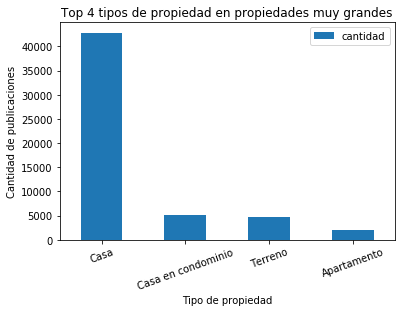

In [27]:
plt.figure(figsize=((2,2)))
df_metros_arreglados["cantidad"] = 1
por_tamanio_y_tipo = df_metros_arreglados.groupby(["clasif_tamanio", "tipodepropiedad"]).agg({"cantidad":np.sum}).reset_index().set_index("tipodepropiedad")
g = por_tamanio_y_tipo.loc[por_tamanio_y_tipo["clasif_tamanio"] == "Muy grande"].nlargest(4,columns="cantidad").plot(kind = "bar", rot=20)
plt.title("Top 4 tipos de propiedad en propiedades muy grandes")
g.set_xlabel("Tipo de propiedad")
g.set_ylabel("Cantidad de publicaciones")

Text(0.5, 1.0, 'Muy grandes')

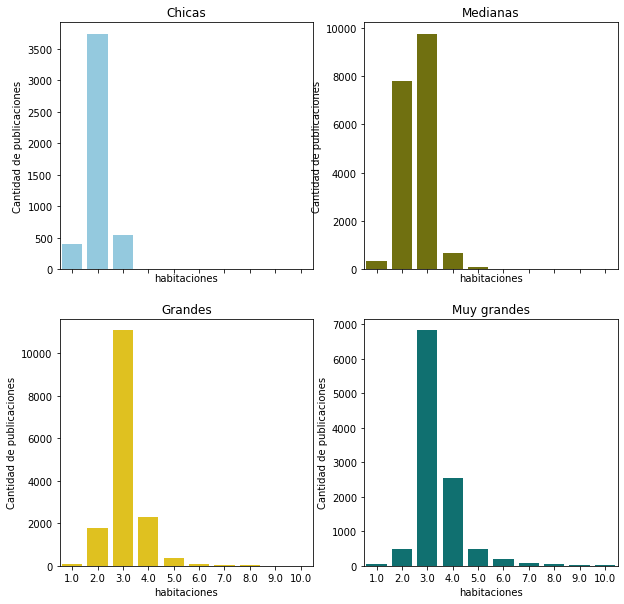

In [28]:
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True,)


df_sin_nulos = df_metros_arreglados.copy().dropna(inplace=False)
plt.setp(axes, xticks=[1,2,3,4,5,6,7,8,9,10], xticklabels=[1,2,3,4,5,6,7,8,9,10])
df_sin_nulos["cantidad"] = 1
por_habitaciones = df_sin_nulos.groupby(["clasif_tamanio","habitaciones"]).agg({"cantidad":sum}).reset_index().copy()

a = sns.barplot( x="habitaciones", y="cantidad" , data=por_habitaciones.loc[por_habitaciones["clasif_tamanio"] == "Chico"],color="skyblue", ax=axes[0, 0])
b = sns.barplot(x="habitaciones", y="cantidad" , data=por_habitaciones.loc[por_habitaciones["clasif_tamanio"] == "Mediano",] , color="olive", ax=axes[0, 1] )
c = sns.barplot(x="habitaciones", y="cantidad" , data=por_habitaciones.loc[por_habitaciones["clasif_tamanio"] == "Grande", ] , color="gold", ax=axes[1, 0] )
d = sns.barplot(x="habitaciones", y="cantidad" , data=por_habitaciones.loc[por_habitaciones["clasif_tamanio"] == "Muy grande"] , color="teal", ax=axes[1, 1])
a.set_ylabel("Cantidad de publicaciones")
b.set_ylabel("Cantidad de publicaciones")
c.set_ylabel("Cantidad de publicaciones")
d.set_ylabel("Cantidad de publicaciones")
axes[0,0].set_title("Chicas")
axes[0,1].set_title("Medianas")
axes[1,0].set_title("Grandes")
axes[1,1].set_title("Muy grandes")



Text(0.5, 1.0, 'Muy grandes')

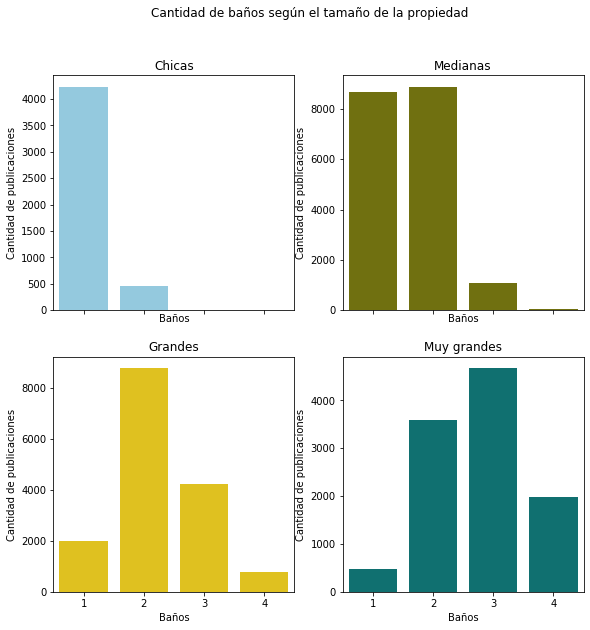

In [29]:

f, axes = plt.subplots(2, 2, figsize=(9.5, 9.5), sharex=True,)
plt.setp(axes, xticks=[1,2,3,4], xticklabels=[1,2,3,4])

por_banos = df_sin_nulos.groupby(["clasif_tamanio","banos"]).agg({"cantidad":sum}).reset_index().copy()
por_banos["Baños"] = por_banos["banos"] 
a = sns.barplot( x="Baños", y="cantidad" , data=por_banos.loc[por_banos["clasif_tamanio"] == "Chico"],color="skyblue", ax=axes[0, 0])
b = sns.barplot(x="Baños", y="cantidad" , data=por_banos.loc[por_banos["clasif_tamanio"] == "Mediano",] , color="olive", ax=axes[0, 1] )
c = sns.barplot(x="Baños", y="cantidad" , data=por_banos.loc[por_banos["clasif_tamanio"] == "Grande", ] , color="gold", ax=axes[1, 0] )
d = sns.barplot(x="Baños", y="cantidad" , data=por_banos.loc[por_banos["clasif_tamanio"] == "Muy grande"] , color="teal", ax=axes[1, 1])
a.set_ylabel("Cantidad de publicaciones")
b.set_ylabel("Cantidad de publicaciones")
c.set_ylabel("Cantidad de publicaciones")
d.set_ylabel("Cantidad de publicaciones")


plt.suptitle("Cantidad de baños según el tamaño de la propiedad")

axes[0,0].set_title("Chicas")
axes[0,0].set_xticklabels([1,2,3,4])
axes[0,1].set_title("Medianas")
axes[1,0].set_title("Grandes")
axes[1,1].set_title("Muy grandes")


Text(0.5, 1.0, 'Muy grandes')

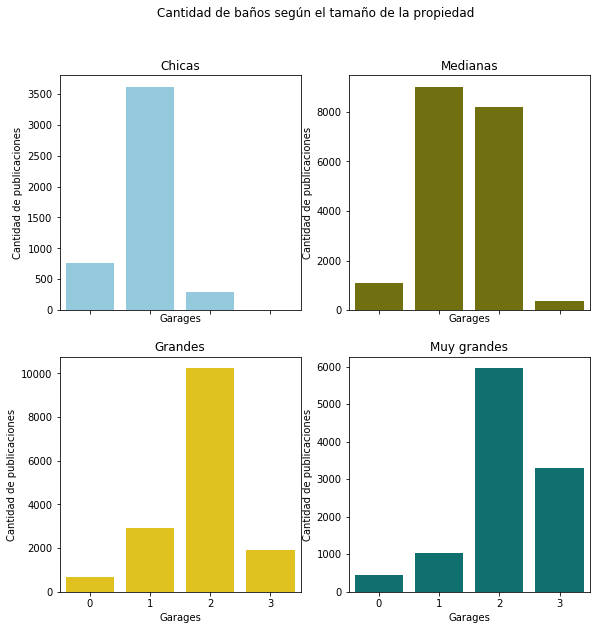

In [30]:

f, axes = plt.subplots(2, 2, figsize=(9.5, 9.5), sharex=True,)
plt.setp(axes, xticks=[0,1,2,3,4,5,6,7,8,9], xticklabels=[0,1,2,3,4,5,6,7,8,9])

por_garages = df_sin_nulos.groupby(["clasif_tamanio","garages"]).agg({"cantidad":sum}).reset_index().copy()
por_garages["Garages"] = por_garages["garages"] 
a = sns.barplot( x="Garages", y="cantidad" , data=por_garages.loc[por_garages["clasif_tamanio"] == "Chico"],color="skyblue", ax=axes[0, 0])
b = sns.barplot(x="Garages", y="cantidad" , data=por_garages.loc[por_garages["clasif_tamanio"] == "Mediano",] , color="olive", ax=axes[0, 1] )
c = sns.barplot(x="Garages", y="cantidad" , data=por_garages.loc[por_garages["clasif_tamanio"] == "Grande", ] , color="gold", ax=axes[1, 0] )
d = sns.barplot(x="Garages", y="cantidad" , data=por_garages.loc[por_garages["clasif_tamanio"] == "Muy grande"] , color="teal", ax=axes[1, 1])
a.set_ylabel("Cantidad de publicaciones")
b.set_ylabel("Cantidad de publicaciones")
c.set_ylabel("Cantidad de publicaciones")
d.set_ylabel("Cantidad de publicaciones")


plt.suptitle("Cantidad de baños según el tamaño de la propiedad")

axes[0,0].set_title("Chicas")
axes[0,0].set_xticklabels([0,1,2,3,4,5,6,7,8,9])
axes[0,1].set_title("Medianas")
axes[1,0].set_title("Grandes")
axes[1,1].set_title("Muy grandes")


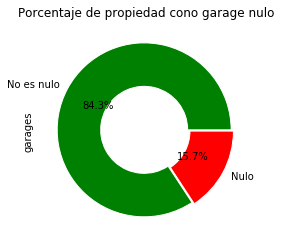

In [31]:
df["garages"].isna().value_counts().plot("pie", title = "Porcentaje de propiedad cono garage nulo",\
    labels=["No es nulo", "Nulo"], wedgeprops={"width":0.5, "edgecolor":'w'}, explode = [0.03,0], autopct='%1.1f%%',
                                    colors = ["green", "red"])


Podemos ver como tenemos una cantidad importante de nulos en la categoría de garage y supondremos que aquellas propiedaddes que lo tengan nulo significa que NO tienen garage. Entonces los rellenaremos con 0.

Text(0.5, 1.0, 'Muy grandes')

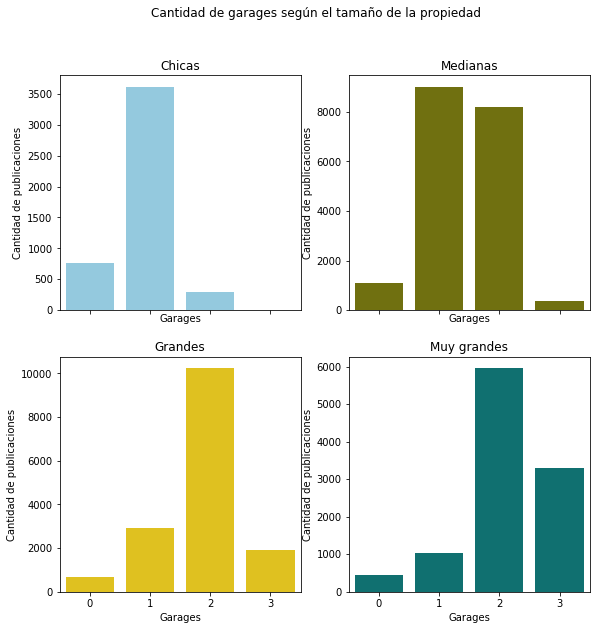

In [32]:
f, axes = plt.subplots(2, 2, figsize=(9.5, 9.5), sharex=True,)
plt.setp(axes, xticks=[0,1,2,3,4,5,6,7,8,9], xticklabels=[0,1,2,3,4,5,6,7,8,9])
df_copia = df_metros_arreglados.copy()

df["garages"] = df_copia["garages"].fillna(0)
df_copia.dropna(inplace=True)
df_copia["cantidad"] = 1
por_garages = df_copia.groupby(["clasif_tamanio","garages"]).agg({"cantidad":np.sum}).reset_index()
por_garages["Garages"] = por_garages["garages"] 
a = sns.barplot( x="Garages", y="cantidad" , data=por_garages.loc[por_garages["clasif_tamanio"] == "Chico"],color="skyblue", ax=axes[0, 0])
b = sns.barplot(x="Garages", y="cantidad" , data=por_garages.loc[por_garages["clasif_tamanio"] == "Mediano",] , color="olive", ax=axes[0, 1] )
c = sns.barplot(x="Garages", y="cantidad" , data=por_garages.loc[por_garages["clasif_tamanio"] == "Grande", ] , color="gold", ax=axes[1, 0] )
d = sns.barplot(x="Garages", y="cantidad" , data=por_garages.loc[por_garages["clasif_tamanio"] == "Muy grande"] , color="teal", ax=axes[1, 1])
a.set_ylabel("Cantidad de publicaciones")
b.set_ylabel("Cantidad de publicaciones")
c.set_ylabel("Cantidad de publicaciones")
d.set_ylabel("Cantidad de publicaciones")
plt.suptitle("Cantidad de garages según el tamaño de la propiedad")
axes[0,0].set_title("Chicas")
axes[0,0].set_xticklabels([0,1,2,3,4,5,6,7,8,9])
axes[0,1].set_title("Medianas")
axes[1,0].set_title("Grandes")
axes[1,1].set_title("Muy grandes")

Evidentemente, por como lo estamos graficando, ingresar en los valores que tenían nulos un 0 no hizo una gran diferencia 

### Precio en funcion del tamaño

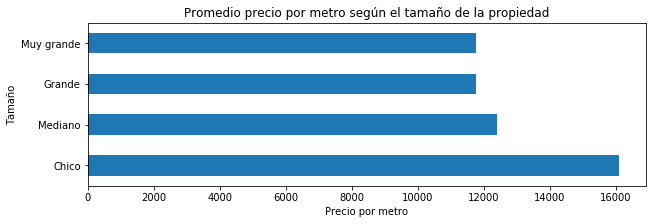

Text(0, 0.5, 'Tamaño')

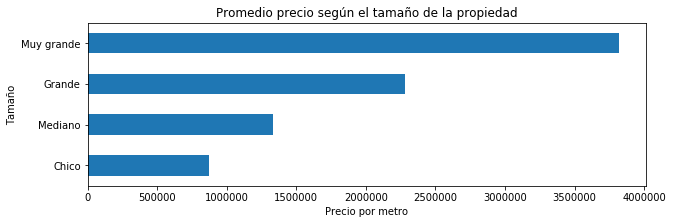

In [46]:
plt.figure(figsize=(10,3))
df_metros_arreglados["precioxmetro"] = df_metros_arreglados["precio"] / df_metros_arreglados["metrostotales"]
precioxmetro_tamanio = df_metros_arreglados.groupby(["clasif_tamanio"]).agg({"precioxmetro":np.mean})
g = precioxmetro_tamanio.reindex(["Chico", "Mediano", "Grande", "Muy grande"])["precioxmetro"].plot(kind="barh")
plt.title("Promedio precio por metro según el tamaño de la propiedad")
g.set_xlabel("Precio por metro")
g.set_ylabel("Tamaño")
plt.show()
plt.figure(figsize=(10,3))

h = df_metros_arreglados.groupby(["clasif_tamanio"]).agg({"precio":np.mean})\
    .reindex(["Chico", "Mediano", "Grande", "Muy grande"])["precio"].plot(kind="barh")
plt.title("Promedio precio según el tamaño de la propiedad")
h.set_xlabel("Precio por metro")
h.set_ylabel("Tamaño")


Text(0.5, 1, 'Heatmap de el precio en función de el tamaño de la propiedad y cantidad de baños')

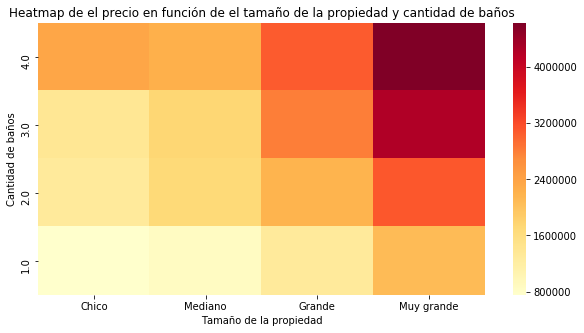

In [47]:
metros_banios_precio = df_metros_arreglados[["metrostotales", "banos","clasif_tamanio" , "habitaciones","precio"]].copy().dropna(inplace=False)
metros_banios_precio.head()
pivoteado = pd.pivot_table(metros_banios_precio, index="banos", columns = "clasif_tamanio", values="precio", fill_value=0)
pivoteado.sort_index(ascending=False, inplace=True)
pivoteado = pivoteado[["Chico", "Mediano", "Grande", "Muy grande"]]

plt.figure(figsize=(10,5))
g = sns.heatmap(pivoteado, cmap="YlOrRd")
g.set_xlabel("Tamaño de la propiedad")
g.set_ylabel("Cantidad de baños")
plt.title("Heatmap de el precio en función de el tamaño de la propiedad y cantidad de baños")

clasif_tamanio         Chico        Grande       Mediano    Muy grande
habitaciones                                                          
10.0            6.000000e+05  3.662857e+06  1.363571e+06  3.821544e+06
9.0             0.000000e+00  1.809091e+06  1.055000e+06  3.719954e+06
8.0             0.000000e+00  2.530273e+06  1.776667e+06  3.396660e+06
7.0             1.500000e+06  2.219617e+06  1.322727e+06  3.264342e+06
6.0             3.850000e+06  1.827840e+06  1.579576e+06  3.145062e+06
5.0             8.100000e+05  1.931831e+06  1.387940e+06  3.501334e+06
4.0             1.101135e+06  2.223116e+06  1.207915e+06  4.063668e+06
3.0             7.600849e+05  2.347279e+06  1.308933e+06  4.017716e+06
2.0             7.748506e+05  2.282607e+06  1.331006e+06  2.719709e+06
1.0             1.242669e+06  1.633965e+06  1.811317e+06  2.239204e+06


Text(0.5, 1, 'Heatmap de el precio en función de el tamaño de la propiedad y cantidad de habitaciones')

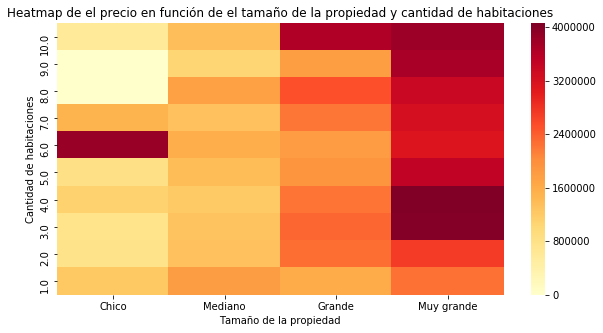

In [48]:
pivoteado2 = pd.pivot_table(metros_banios_precio, index="habitaciones", columns = "clasif_tamanio", values="precio", fill_value=0)
pivoteado2.sort_index(ascending=False, inplace=True)
print(pivoteado2)
pivoteado2 = pivoteado2[["Chico", "Mediano", "Grande", "Muy grande"]]

plt.figure(figsize=(10,5))
g = sns.heatmap(pivoteado2, cmap="YlOrRd")
g.set_xlabel("Tamaño de la propiedad")
g.set_ylabel("Cantidad de habitaciones")
plt.title("Heatmap de el precio en función de el tamaño de la propiedad y cantidad de habitaciones")

#### Trato de analizar las categorías booleanas

Veremos cuanto afectan al precio segun el tamaño de la propiedad, que tengan estos agregados las propiedades

In [49]:
categorias_booleanas = df_metros_arreglados[["clasif_tamanio", "gimnasio", "usosmultiples", "piscina",\
                                             "escuelascercanas","centroscomercialescercanos", "precio", "precioxmetro"]]

#### Gimnasio

Text(0, 0.5, 'Precio')

<Figure size 720x360 with 0 Axes>

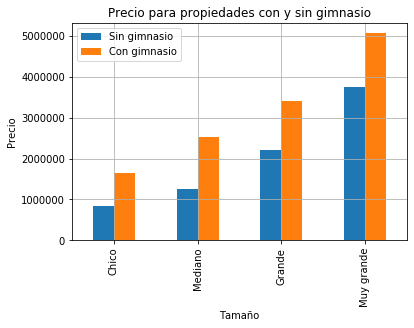

In [50]:
precio_gimnasio = pd.pivot_table(categorias_booleanas, index = "clasif_tamanio", columns = "gimnasio", values="precio")
precio_gimnasio.columns = ["Sin gimnasio", "Con gimnasio"]
plt.figure(figsize=(10,5))
g = precio_gimnasio.reindex(["Chico", "Mediano", "Grande", "Muy grande"]).reset_index().plot.bar(x="clasif_tamanio", y=["Sin gimnasio", "Con gimnasio"], grid = True)
plt.title("Precio para propiedades con y sin gimnasio")
g.set_xlabel("Tamaño")
g.set_ylabel("Precio")


Text(0, 0.5, 'Precio por metro')

<Figure size 720x360 with 0 Axes>

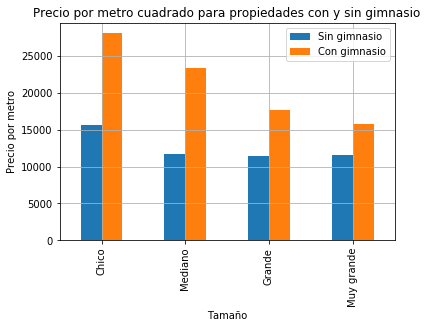

In [51]:
#categorias_booleanas.groupby(["clasif_tamanio","gimnasio"]).agg({"precio":"mean"}).plot(kind="bar", color = "#FFC222")
precio_gimnasio = pd.pivot_table(categorias_booleanas, index = "clasif_tamanio", columns = "gimnasio", values="precioxmetro")
precio_gimnasio.columns = ["Sin gimnasio", "Con gimnasio"]
plt.figure(figsize=(10,5))
g = precio_gimnasio.reindex(["Chico", "Mediano", "Grande", "Muy grande"]).reset_index().plot.bar(x="clasif_tamanio", y=["Sin gimnasio", "Con gimnasio"], grid = True)
plt.title("Precio por metro cuadrado para propiedades con y sin gimnasio")
g.set_xlabel("Tamaño")
g.set_ylabel("Precio por metro")


#### Piscina

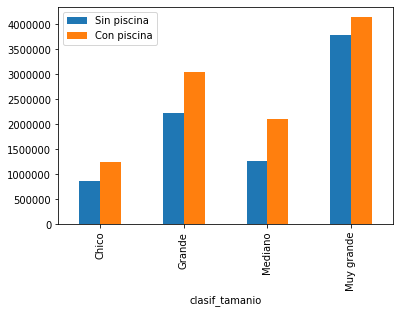

In [250]:
precio_piscina = pd.pivot_table(categorias_booleanas, index = "clasif_tamanio", columns = "piscina", values="precio")
precio_piscina.columns = ["Sin piscina", "Con piscina"]
precio_piscina.reset_index().plot.bar(x="clasif_tamanio", y=precio_piscina.columns)

Text(0, 0.5, 'Precio por metro')

<Figure size 720x360 with 0 Axes>

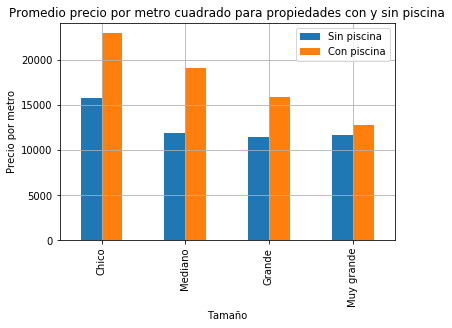

In [53]:
precio_piscina = pd.pivot_table(categorias_booleanas, index = "clasif_tamanio", columns = "piscina", values="precioxmetro")
precio_piscina.columns = ["Sin piscina", "Con piscina"]
plt.figure(figsize=(10,5))
g = precio_piscina.reindex(["Chico", "Mediano", "Grande", "Muy grande"]).reset_index().plot.bar(x="clasif_tamanio", y=["Sin piscina", "Con piscina"], grid = True)
plt.title("Promedio precio por metro cuadrado para propiedades con y sin piscina")
g.set_xlabel("Tamaño")
g.set_ylabel("Precio por metro")


#### Usos múltiples

Text(0, 0.5, 'Precio')

<Figure size 720x360 with 0 Axes>

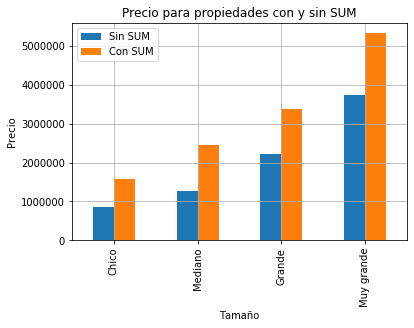

In [54]:
precio_SUM = pd.pivot_table(categorias_booleanas, index = "clasif_tamanio", columns = "usosmultiples", values="precio")
precio_SUM.columns = ["Sin SUM", "Con SUM"]
plt.figure(figsize=(10,5))
g = precio_SUM.reindex(["Chico", "Mediano", "Grande", "Muy grande"]).reset_index().plot.bar(x="clasif_tamanio", y=precio_SUM.columns, grid = True)
plt.title("Precio para propiedades con y sin SUM")
g.set_xlabel("Tamaño")
g.set_ylabel("Precio")


Text(0, 0.5, 'Precio por metro')

<Figure size 720x360 with 0 Axes>

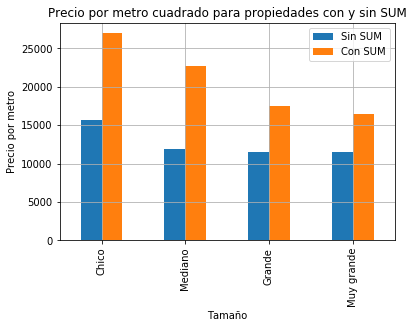

In [55]:
precio_SUM = pd.pivot_table(categorias_booleanas, index = "clasif_tamanio", columns = "usosmultiples", values="precioxmetro")
precio_SUM.columns = ["Sin SUM", "Con SUM"]
plt.figure(figsize=(10,5))
g = precio_SUM.reindex(["Chico", "Mediano", "Grande", "Muy grande"]).reset_index().plot.bar(x="clasif_tamanio", y=["Sin SUM", "Con SUM"], grid = True)
plt.title("Precio por metro cuadrado para propiedades con y sin SUM")
g.set_xlabel("Tamaño")
g.set_ylabel("Precio por metro")


#### Escuelas cercanas

Text(0, 0.5, 'Precio')

<Figure size 720x360 with 0 Axes>

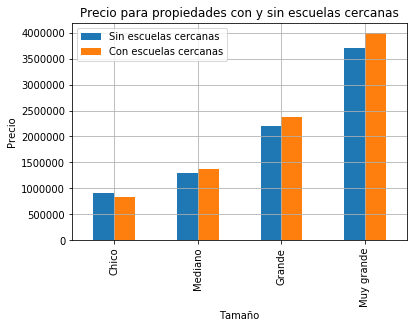

In [56]:
precio_escuelas = pd.pivot_table(categorias_booleanas, index = "clasif_tamanio", columns = "escuelascercanas", values="precio")
precio_escuelas.columns = ["Sin escuelas cercanas", "Con escuelas cercanas"]
plt.figure(figsize=(10,5))
g = precio_escuelas.reindex(["Chico", "Mediano", "Grande", "Muy grande"]).reset_index().plot.bar(x="clasif_tamanio", y=["Sin escuelas cercanas", "Con escuelas cercanas"], grid = True)
plt.title("Precio para propiedades con y sin escuelas cercanas")
g.set_xlabel("Tamaño")
g.set_ylabel("Precio")

Text(0, 0.5, 'Precio por metro')

<Figure size 720x360 with 0 Axes>

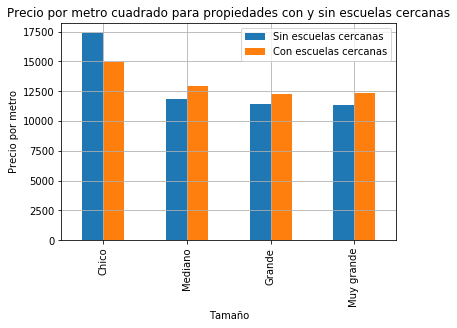

In [57]:
precio_escuelas = pd.pivot_table(categorias_booleanas, index = "clasif_tamanio", columns = "escuelascercanas", values="precioxmetro")
precio_escuelas.columns = ["Sin escuelas cercanas", "Con escuelas cercanas"]
plt.figure(figsize=(10,5))
g = precio_escuelas.reindex(["Chico", "Mediano", "Grande", "Muy grande"]).reset_index().plot.bar(x="clasif_tamanio", y=["Sin escuelas cercanas", "Con escuelas cercanas"], grid = True)
plt.title("Precio por metro cuadrado para propiedades con y sin escuelas cercanas")
g.set_xlabel("Tamaño")
g.set_ylabel("Precio por metro")


#### Centros comerciales

Text(0, 0.5, 'Precio')

<Figure size 720x360 with 0 Axes>

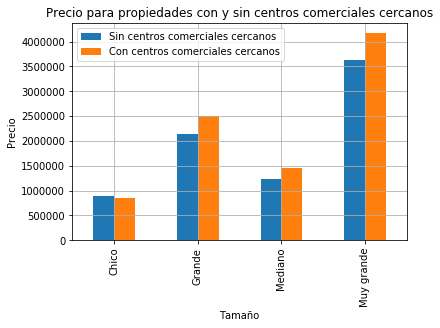

In [259]:
precio_cc = pd.pivot_table(categorias_booleanas, index = "clasif_tamanio", columns = "centroscomercialescercanos", values="precio")
precio_cc.columns = ["Sin centros comerciales cercanos", "Con centros comerciales cercanos"]
plt.figure(figsize=(10,5))
g = precio_cc.reset_index().plot.bar(x="clasif_tamanio", y=["Sin centros comerciales cercanos", "Con centros comerciales cercanos"], grid = True)
plt.title("Precio para propiedades con y sin centros comerciales cercanos")
g.set_xlabel("Tamaño")
g.set_ylabel("Precio")

Text(0, 0.5, 'Precio por metro')

<Figure size 720x360 with 0 Axes>

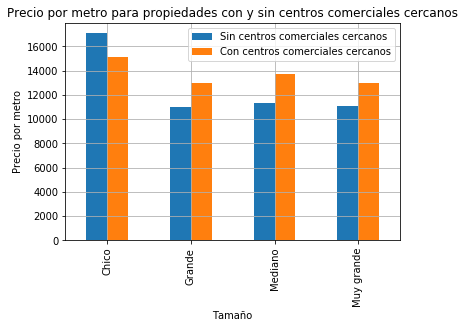

In [260]:
precio_cc = pd.pivot_table(categorias_booleanas, index = "clasif_tamanio", columns = "centroscomercialescercanos", values="precioxmetro")
precio_cc.columns = ["Sin centros comerciales cercanos", "Con centros comerciales cercanos"]
plt.figure(figsize=(10,5))
g = precio_cc.reset_index().plot.bar(x="clasif_tamanio", y=["Sin centros comerciales cercanos", "Con centros comerciales cercanos"], grid = True)
plt.title("Precio por metro para propiedades con y sin centros comerciales cercanos")
g.set_xlabel("Tamaño")
g.set_ylabel("Precio por metro")

Capaz porque hay mas oferta, o que sea una zona por ende mas superpoblada y mas fea.

In [1]:
plt.figure(figsize=(12, 7))
plt.ticklabel_format(style='plain', axis='y')
lista = df.groupby(["tipodepropiedad"]).agg({"cantidad":sum}).sort_values("cantidad",ascending = False).head(5)
lista = lista.index.to_list()
principales = df[df["tipodepropiedad"].isin(lista)].copy()
sns.boxplot(x='tipodepropiedad', y='metrostotales', data=principales, palette='colorblind', showfliers=False).set_title('Metros totales por tipo de propiedad')

NameError: name 'plt' is not defined